# True Impact Shot Charting

This notebook contains step-by-step code snippets to load and explore NBA tracking data as it relates to off rebounding/fastbreak scenario scoring impacts. Walk through the cells below to interact with the data, generate features, and produce results. All relevant code classes are pre-imported, and the source code can be found and manipulated under the 'code' directory in the repo.

In [1]:
# Change this to any valid gameId in the source data
GAME_ID = "0022300869"

# Each source file has a dedicated processor class, use these to load and process src data
event_df = EventProcessor.load_game(GAME_ID)
tracking_df = TrackingProcessor.load_game(GAME_ID)
possession_df = PossessionProcessor.load_game(GAME_ID)

### 1. Begin by extracting and visualizing some data

In [2]:
anim = VisUtil(tracking_df)
anim.display_animation(possession_df.loc[possession_df["outcome"] == "FGM"].iloc[0])

### 2. Next, let's link the datasets together, and take a look at some raw data

In [13]:
# Extract transition events from the raw data, we will focus on the first example here
transition_events = EventProcessor.extract_transition_opportunities(event_df)
event = transition_events[0]

# Collect the timestamps at the start and end of the event, use that to collect coresponding tracking/possession info
start, end = EventProcessor.get_start_end_time_of_event(event)
moment_df = TrackingProcessor.extract_moment_from_timestamps(tracking_df, start, end)
possession = PossessionProcessor.extract_possession_by_timestamp(possession_df, end)

moment_df

,gameId,playerId,playerName,teamId,teamAbbr,period,wcTime,gcTime,scTime,x,y,z,gameDate
0,0022300869,1631128,Christian Braun,1610612743,DEN,1,1709430117960,681.1,24.00,-13.21,23.46,0.0,2024-03-02
1,0022300869,1627750,Jamal Murray,1610612743,DEN,1,1709430117960,681.1,24.00,-32.87,7.51,0.0,2024-03-02
2,0022300869,203932,Aaron Gordon,1610612743,DEN,1,1709430117960,681.1,24.00,-20.65,7.98,0.0,2024-03-02
3,0022300869,1629008,Michael Porter Jr.,1610612743,DEN,1,1709430117960,681.1,24.00,-39.25,1.33,0.0,2024-03-02
4,0022300869,203999,Nikola Jokic,1610612743,DEN,1,1709430117960,681.1,24.00,-44.23,1.12,0.0,2024-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,0022300869,1630559,Austin Reaves,1610612747,LAL,1,1709430135360,663.7,7.63,27.94,-6.26,0.0,2024-03-02
4792,0022300869,2544,LeBron James,1610612747,LAL,1,1709430135360,663.7,7.63,43.28,10.76,0.0,2024-03-02
4793,0022300869,1626156,DAngelo Russell,1610612747,LAL,1,1709430135360,663.7,7.63,15.79,10.41,0.0,2024-03-02
4794,0022300869,203076,Anthony Davis,1610612747,LAL,1,1709430135360,663.7,7.63,36.27,-7.10,0.0,2024-03-02


### 3. Now that we are comfortable with the data, let's use our FeatureUtil to engineer some transition defense features

In [14]:
# Now we can generate our features
cross_3pt = FeatureUtil.find_ball_crossing_far_three_point_line(moment_df, possession["basketX"])
cross_half = FeatureUtil.find_ball_crossing_halfcourt(moment_df, possession["basketX"])
in_zone_of_death = FeatureUtil.find_ball_moment(moment_df, FeatureUtil.is_in_zone_of_death, possession["basketX"])

# Here, our FeatureUtil uses a set of boolean methods applied using vectorization to extract relevant game event timestamps
print(cross_3pt, cross_half, in_zone_of_death)

{'timestamp': 1709430122560, 'x': 18.22, 'y': -13.94} {'timestamp': 1709430117960, 'x': -40.83, 'y': 0.59} {'timestamp': 1709430117960, 'x': -40.83, 'y': 0.59}


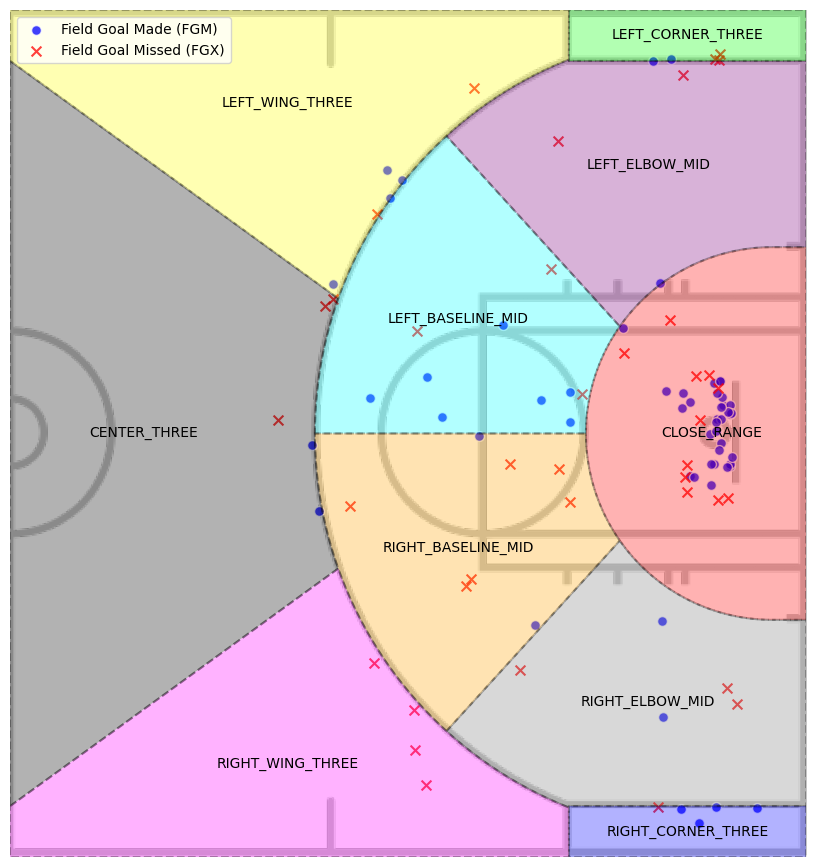

In [11]:
# First, we need to extract all the shot events, link the corresponding rebound event, and associate with coordinate data
shot_rebound_df = ActionProcessor.extract_shots_and_rebounds(event_df, tracking_df)

# Now that we have the shot/rebounds collected, we can use our FeatureUtil to engineer the regions, shots are classified by which polygon contains them
shot_rebound_classified_df = FeatureUtil.classify_shot_locations(shot_rebound_df, possession_df, FeatureUtil.classify_shot_region)

# Finally, plot the resulting data, mirror everything accross halfcourt
VisUtil.plot_shots_and_regions(shot_rebound_classified_df)

### 4. We will attach the shot classifications to our shot/rebound df and leverage it later on. We can then use this classified data to create rebound distribution plots

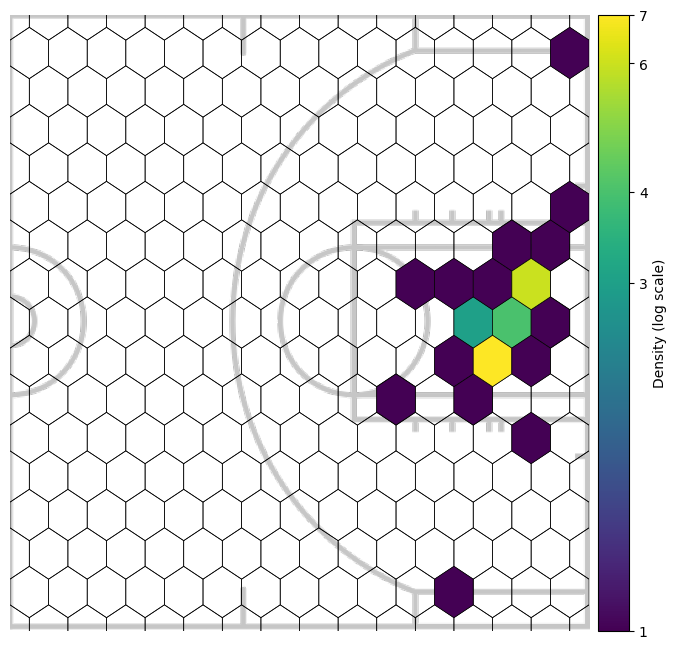

In [12]:
# We use hexbin plots to create probabilty mappings for rebounds based on where the shot originates from
hexbin_region_data_df = StatsUtil.generate_region_hexbin_data(shot_rebound_classified_df, ShotRegionUtil.regions)

# Here is what that distribution looks like across all regions
VisUtil.plot_court_hexmap(shot_rebound_classified_df, 'rebound_x', 'rebound_y')

### 5. We have classified shot data and rebound distributions. Next, we need a way to quantify the geospatial features of the court at the shot time to project which team has the best rebounding chances. We use Voroni cell diagrams to accomplish this

          gameId playerId        playerName      teamId teamAbbr  period  \
0     0022300336  1630168    Onyeka Okongwu  1610612737      ATL       1   
1     0022300336  1629631    DeAndre Hunter  1610612737      ATL       1   
2     0022300336  1629027        Trae Young  1610612737      ATL       1   
3     0022300336  1627749   Dejounte Murray  1610612737      ATL       1   
4     0022300336  1630180        Saddiq Bey  1610612737      ATL       1   
...          ...      ...               ...         ...      ...     ...   
3592  0022300336  1629622         Max Strus  1610612739      CLE       1   
3593  0022300336  1629731         Dean Wade  1610612739      CLE       1   
3594  0022300336  1628378  Donovan Mitchell  1610612739      CLE       1   
3595  0022300336  1628386     Jarrett Allen  1610612739      CLE       1   
3596  0022300336      NaN               NaN          -1      NaN       1   

             wcTime  gcTime  scTime      x      y     z    gameDate  
0     17027737328

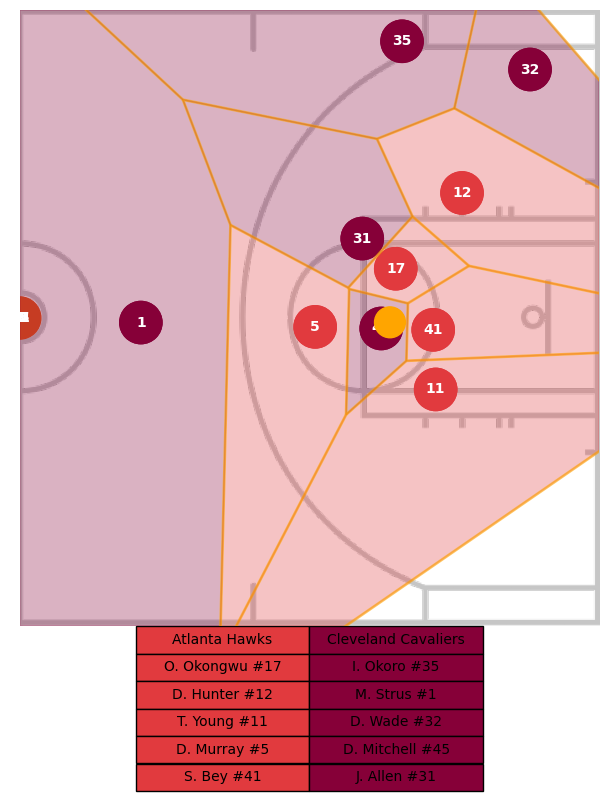

In [5]:
# 
possession = shot_rebound_classified_df.iloc[0]
moment_df = TrackingProcessor.extract_moment_from_timestamps(tracking_df, possession['wcStart'], possession['wcEnd'])
print(moment_df)
moment_df = TrackingProcessor.mirror_court_data(moment_df, 'x', 'y', -possession["basket_x"])
print(moment_df)
anim = VisUtil(moment_df)
anim.plot_voronoi_at_timestamp(possession['shot_time'], -possession["basket_x"])

In [6]:
print(possession)
rebound_regions_df = StatsUtil.generate_region_hexbin_data(shot_rebound_classified_df, ShotRegionUtil.regions)

StatsUtil.calculate_rebound_chances(moment_df, possession['shot_time'], hexbin_region_data_df, 41.75)

Unnamed: 0                                              598
shot_x                                               -30.05
shot_y                                                 0.35
rebound_x                                            -39.46
rebound_y                                              3.98
shot_time                                     1702773744600
rebound_time                                  1702773745880
rebound_teamId                                   1610612737
basket_x                                             -41.75
gameId                                             22300336
period                                                    1
possId                 46150e42-5f57-508b-aa7e-05b0c3e1bc56
possNum                                                   3
teamId                                           1610612739
teamAbbr                                                CLE
outcome                                                 FGX
ptsScored                               

c:\Users\dkste\Dev\TrueImpactShotCharts\code\io\TrackingProcessor.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_df[x_col_name] = tracking_df.apply(
c:\Users\dkste\Dev\TrueImpactShotCharts\code\io\TrackingProcessor.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_df[y_col_name] = tracking_df.apply(
c:\Users\dkste\Dev\TrueImpactShotCharts\code\io\TrackingProcessor.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

({'1630168': 19.30635838150289,
  '1629631': 19.30635838150289,
  '1629027': 19.30635838150289,
  '1627749': 19.30635838150289,
  '1630180': 19.30635838150289,
  '1630171': 0.6936416184971098,
  '1629622': 0.6936416184971098,
  '1629731': 0.6936416184971098,
  '1628378': 0.6936416184971098,
  '1628386': 0.6936416184971098},
 {'1610612737': 96.53179190751445, '1610612739': 3.4682080924855487})

In [10]:
reb_chances_df = StatsUtil.assign_rebound_chances_to_shots(shot_rebound_classified_df, tracking_df, hexbin_region_data_df)
reb_chances_df.to_csv('./../data/results/reb_chances.csv')

In [3]:
# true_point_events = StatsUtil.calculate_true_points(event_df)
# true_point_events.to_csv('true_points.csv')
# true_point_events['true_points_produced'].value_counts()

In [ ]:
true_impact_points_classified_df = pd.read_csv('./../data/results/true_impact_points_classified.csv', dtype={'dReb': pd.BooleanDtype()})

# Plot topographical heatmap using true impact points produced
VisUtil.plot_topographical_heatmap(true_impact_points_classified_df, weight_col="true_impact_points_produced")

# Plot topographical heatmap using points produced
VisUtil.plot_topographical_heatmap(true_impact_points_classified_df, weight_col="points_produced")

# Plot topographical heatmap using true points produced
VisUtil.plot_topographical_heatmap(true_impact_points_classified_df, weight_col="true_points_produced")